## Linear regression model

In this section we fit two linear models to our data:

- AR(∞) using LASSO
- Same but with all regressors using LASSO

### AR(∞) using LASSO

In [ ]:
data = pd.read_csv("data.csv", sep=";")

In [ ]:
# setup
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 

In [ ]:
data = pd.concat([target, regressors], axis=1)

# exclude covid-19
data = data[:'2019-12-31']

# specify split date
split_date = pd.to_datetime('2012-01-01')

# split data based on split date
train = data.loc[data.index < split_date]
test = data.loc[data.index >= split_date]

# get train and test data from data
X_train = train.drop('output_growth_pct', axis=1)
y_train = train['output_growth_pct']
X_test = test.drop('output_growth_pct', axis=1)
y_test = test['output_growth_pct']

In [ ]:
# initialize the StandardScaler
scaler = StandardScaler()

# fit on train data and transform both train and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape,X_test_scaled.shape)

(104, 184) (40, 184)


In [ ]:
# the time series cross-validation splitter
tscv = TimeSeriesSplit(n_splits=5)

# Configure LassoCV with all options set, including default values
lasso_cv = LassoCV(
    alphas=np.logspace(-6, 1, 20),  # Adjust the range of alphas or set to None to use automatic selection
    cv=tscv,                        # Use time series cross-validation
    max_iter=1000,                  # Default is 1000, increase if convergence issues
    tol=0.0001,                     # Default tolerance for optimization
    n_alphas=100,                   # Used only if alphas is None
    fit_intercept=True,             # Whether to fit the intercept (default True)
    normalize=False,                # Normalize data before fitting (default False)
    precompute='auto',              # Whether to use a precomputed Gram matrix to speed up calculations
    copy_X=True,                    # If True, X will be copied; else, it may be overwritten (default True)
    verbose=0,                      # Control verbosity (default 0)
    n_jobs=-1,                      # Number of CPUs to use during the cross validation (default 1)
    positive=False,                 # Restrict coefficients to be positive (default False)
    random_state=42,                # Seed for the random number generator
    selection='cyclic'              # If set to 'random', a random coefficient is updated every iteration (default 'cyclic')
)

lasso_cv = LassoCV(alphas=np.logspace(-6, 1, 100), cv=tscv, random_state=42).fit(X_train_scaled, y_train)

# check the best alpha found
print("Best alpha:", lasso_cv.alpha_)

# fit Lasso model using the best alpha
lasso_best = Lasso(alpha=lasso_cv.alpha_)
lasso_best.fit(X_train_scaled, y_train)
y_pred_best = lasso_best.predict(X_test_scaled)

Best alpha: 0.06428073117284319


In [ ]:
# initialize Lasso with a specific alpha value
lasso_model = Lasso(alpha=lasso_cv.alpha_, 
                    fit_intercept=True,
                    precompute=False,
                    max_iter=1000,
                    tol=0.0001, 
                    warm_start=False, 
                    positive=False, 
                    random_state=42, 
                    selection='cyclic')

# Fit Lasso model on the training data
lasso_model.fit(X_train, y_train)

# Predict on the test set
y_pred = lasso_model.predict(X_test)

# evaluate
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)


Mean Squared Error: 0.24938763759839383
Mean Absolute Error: 0.4173764853322804
R^2 Score: -0.8142694914421806


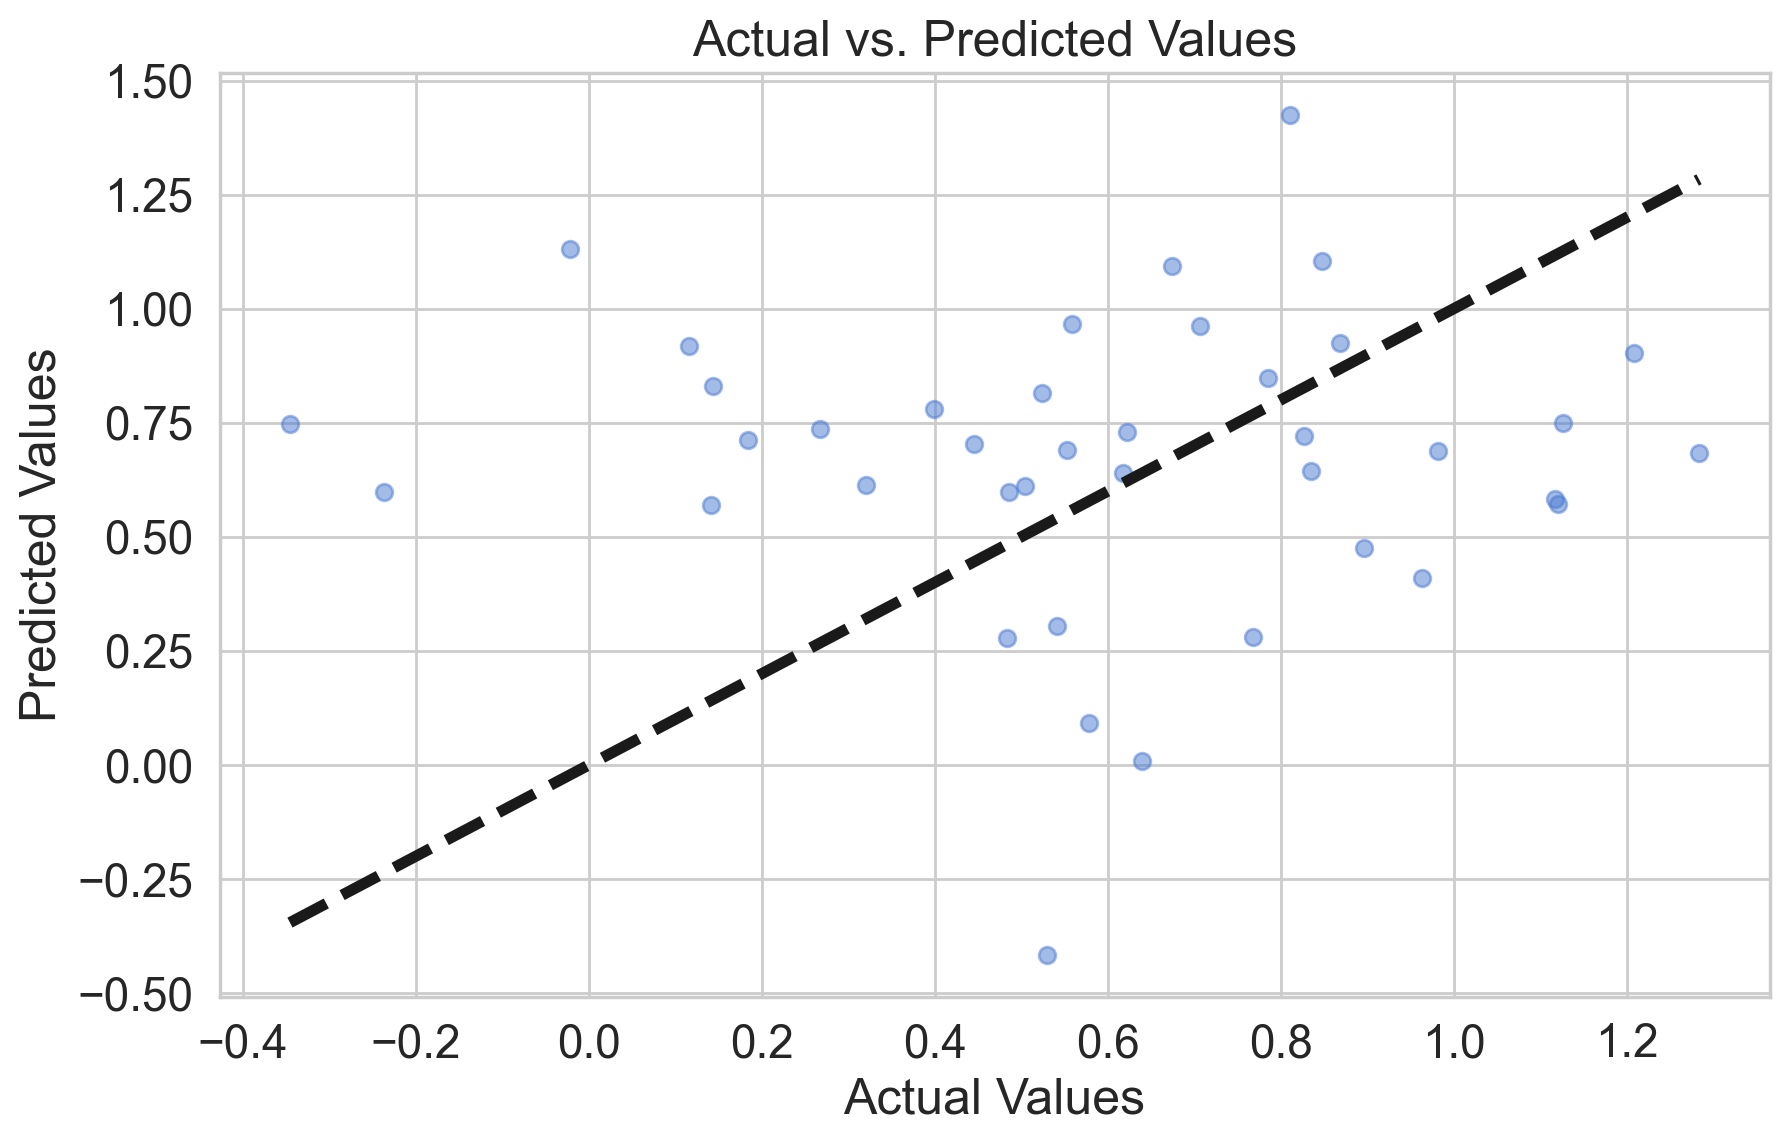

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()


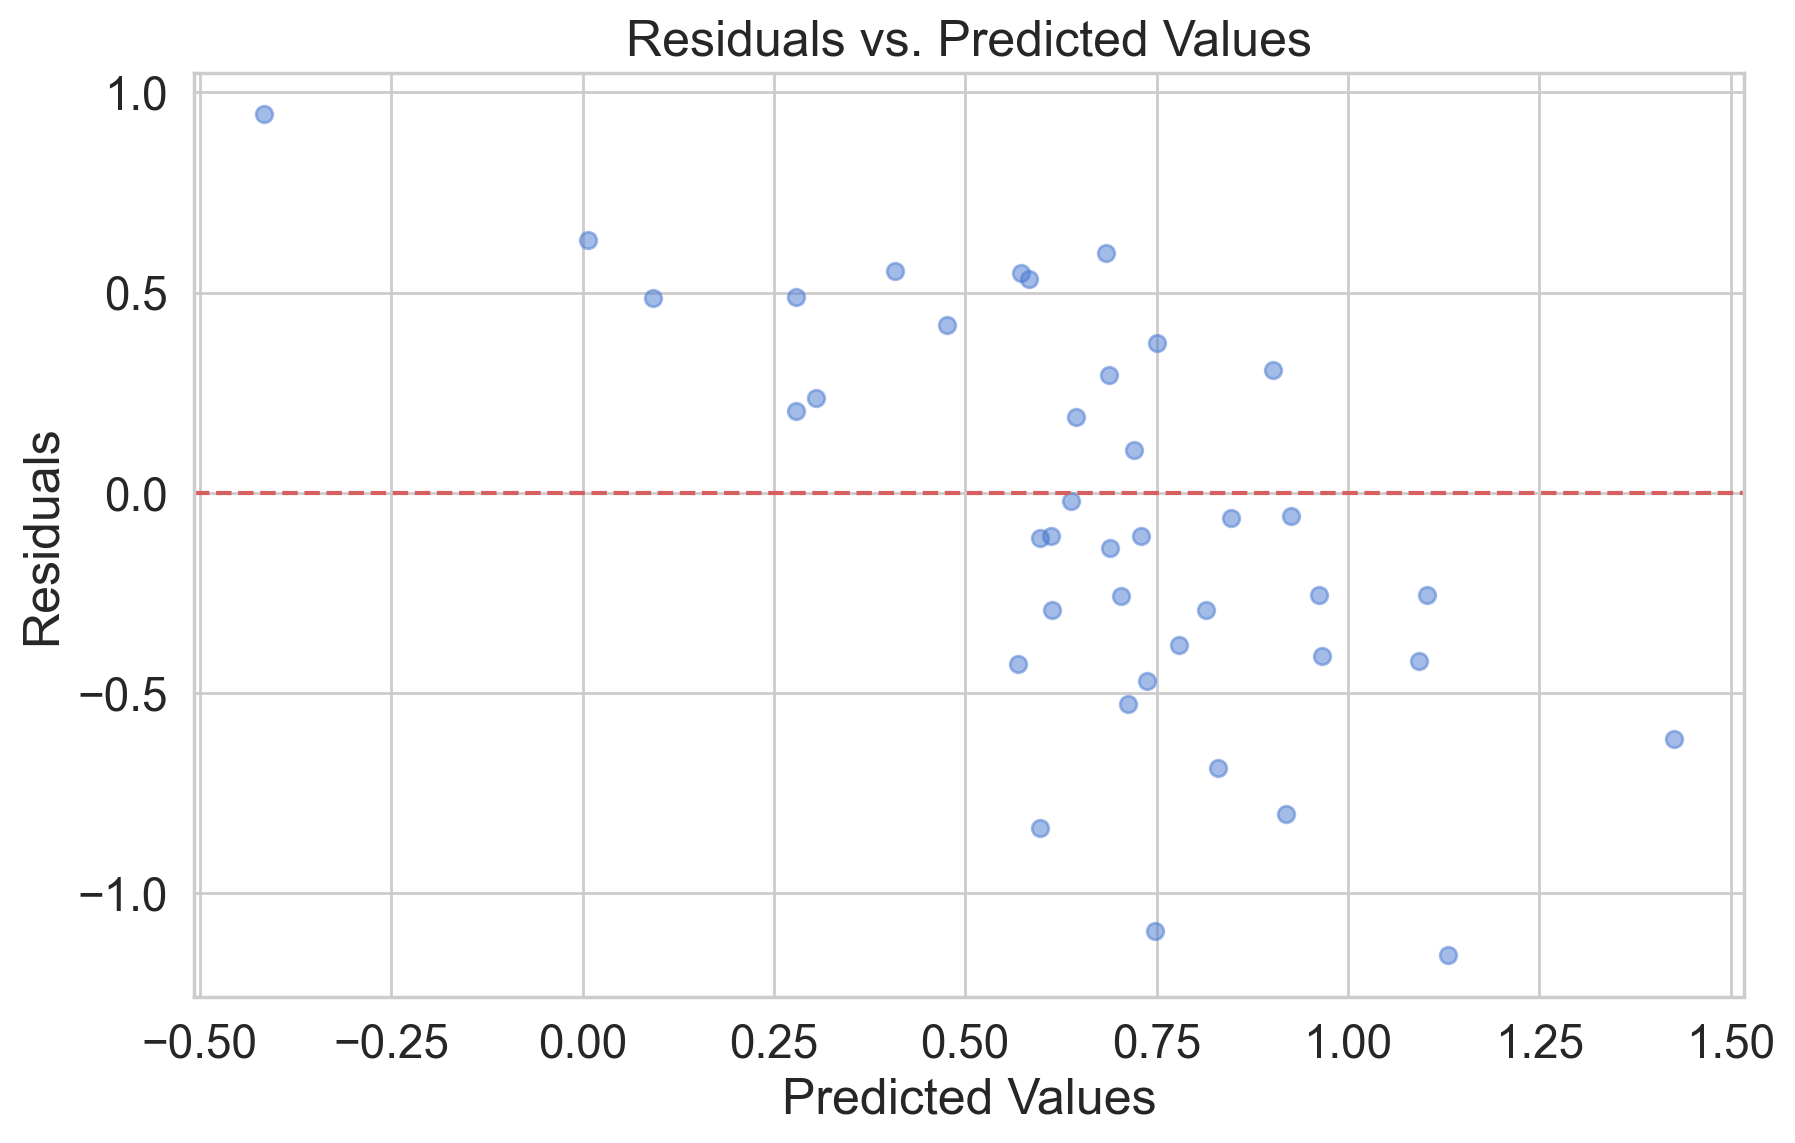

In [ ]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()


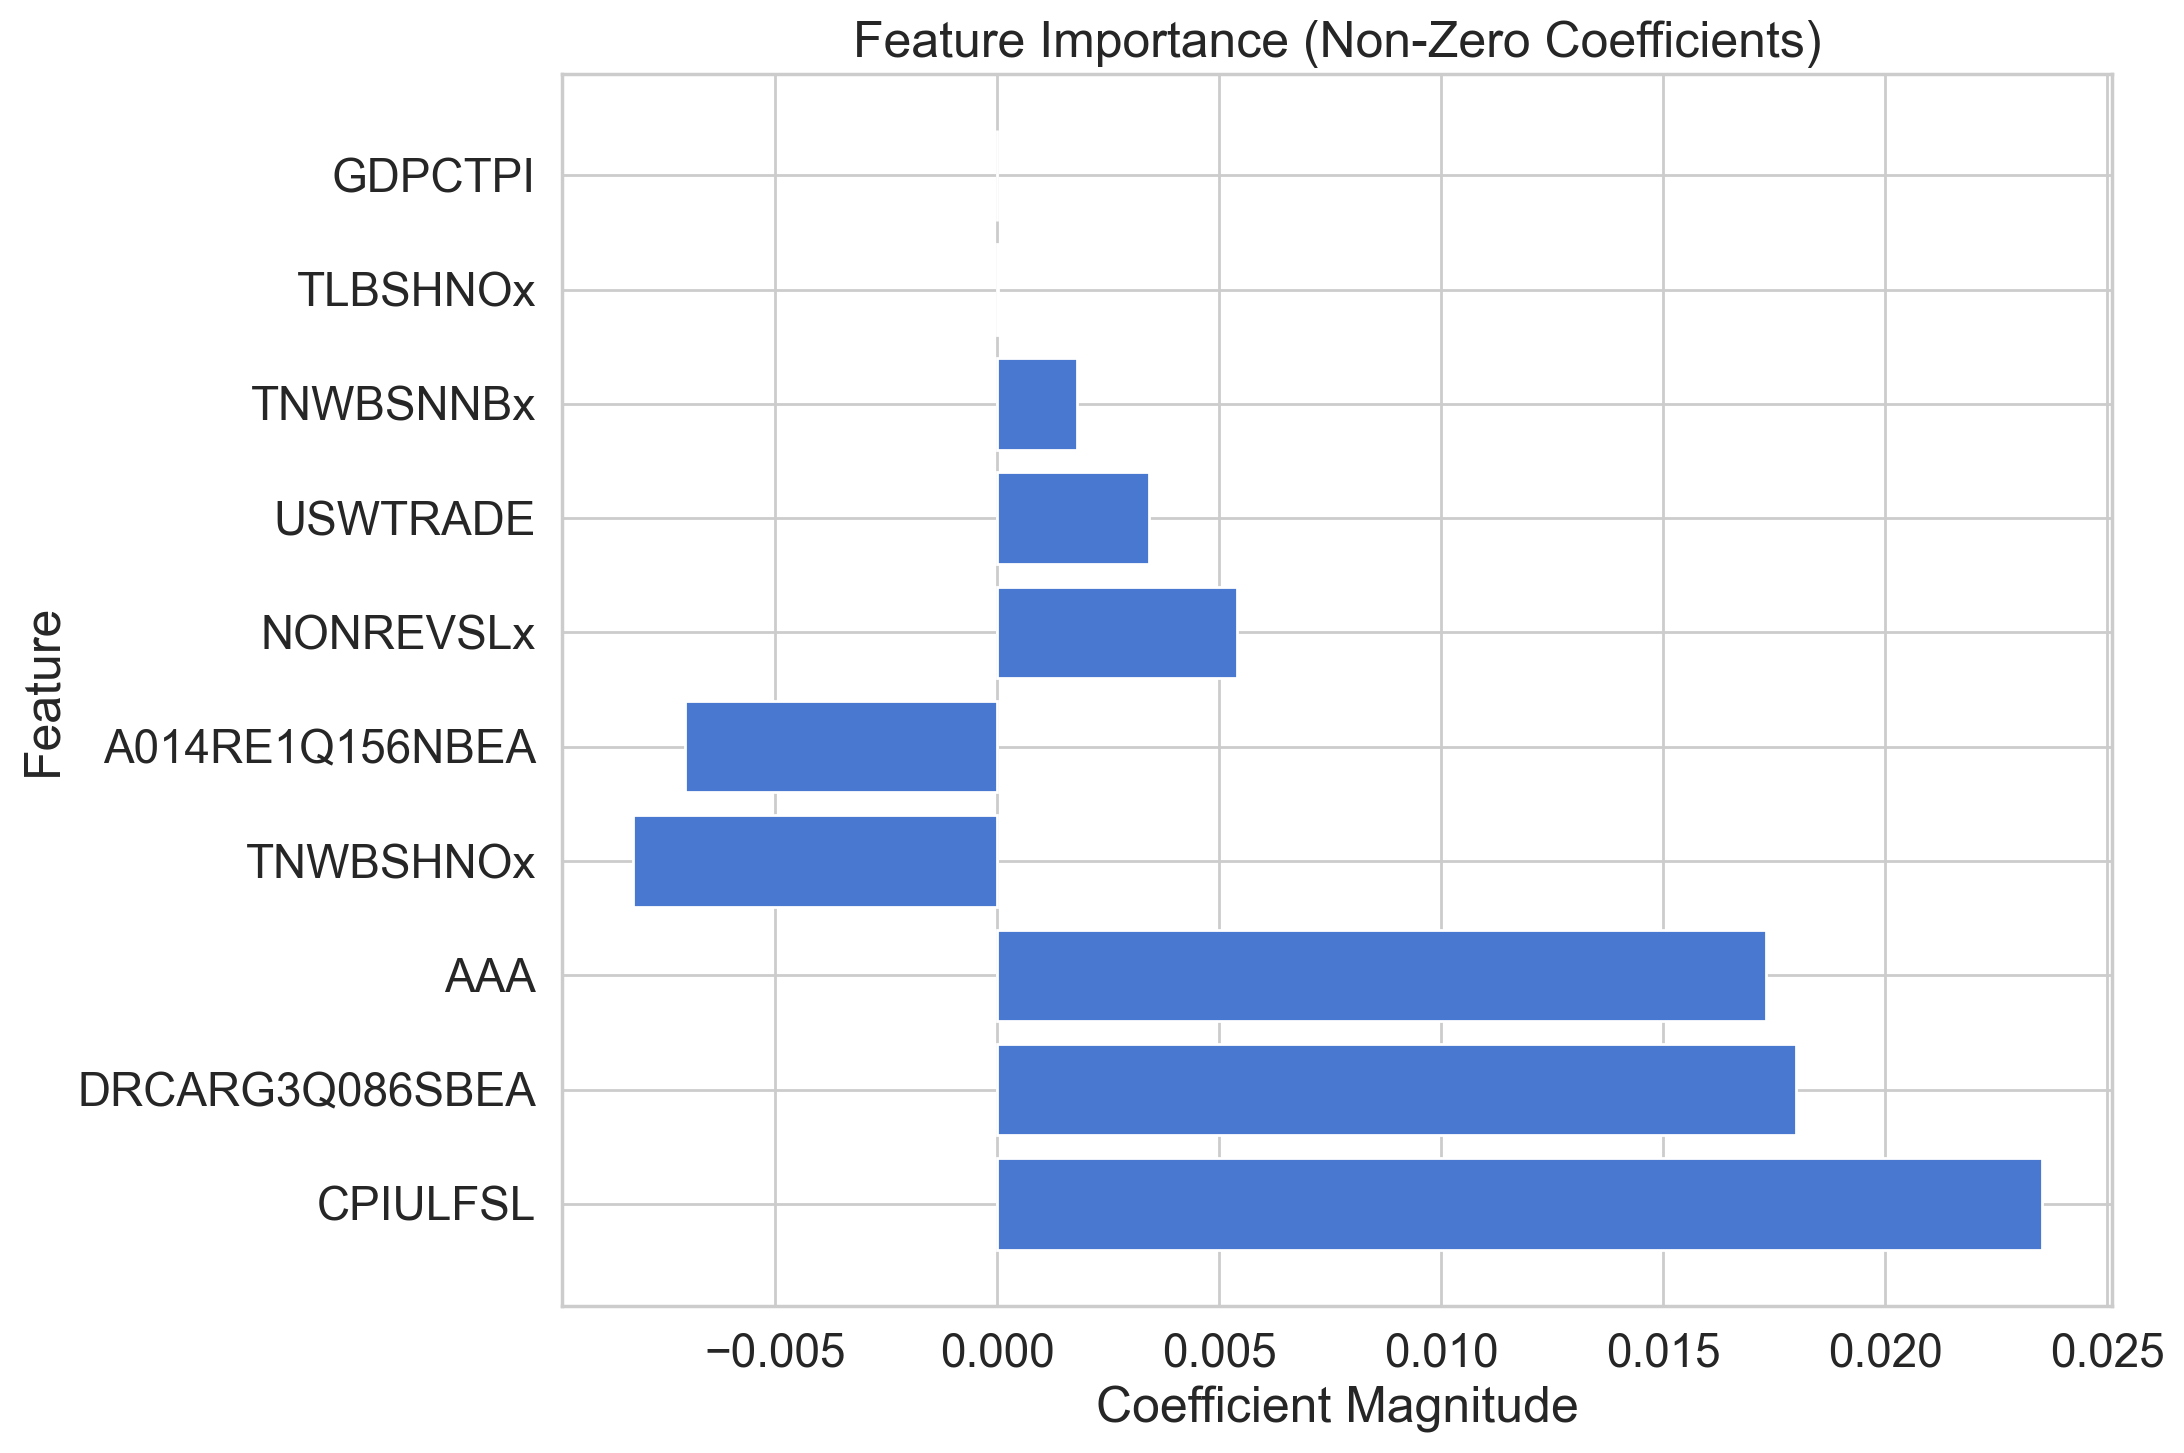

In [ ]:
# Assuming 'lasso_model' is your trained Lasso model
# and 'feature_names' is your list of feature names.

# Get the coefficients from the Lasso model
coefficients = lasso_model.coef_

# Filter out features with zero coefficients
non_zero_indices = np.where(coefficients != 0)[0]  # Get indices where coefficients are non-zero
important_features = np.array(feature_names)[non_zero_indices]
important_coefficients = coefficients[non_zero_indices]

# Sort features by the magnitude of their coefficients for better visualization
sorted_indices = np.argsort(np.abs(important_coefficients))[::-1]
sorted_features = important_features[sorted_indices]
sorted_coefficients = important_coefficients[sorted_indices]

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_coefficients)
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Feature Importance (Non-Zero Coefficients)')
plt.show()


In [ ]:
# Assuming 'lasso' is your trained Lasso model and 'feature_names' is the list of original feature names
selected_features = [feature_names[i] for i, coef in enumerate(lasso_model.coef_) if coef != 0]
print("Selected features by Lasso:", selected_features)

Selected features by Lasso: ['A014RE1Q156NBEA', 'AAA', 'CPIULFSL', 'DRCARG3Q086SBEA', 'GDPCTPI', 'NONREVSLx', 'TLBSHNOx', 'TNWBSHNOx', 'TNWBSNNBx', 'USWTRADE']
